<a href="https://colab.research.google.com/github/docheem/Diffusion-Models/blob/main/1Gen_AI_ML_Architect_L7_Ads_DSE_Streaming_Services.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compressing and Representing Information

This project contain:

- Implementation of AutoEncoder encoder/decoder
- Latent space version
- Sequential rewrite
- Implementation VAE encoder (mu/logvar)
- Reparameterization trick
- Training VAE loop with KL + reconstruction



Data Preparations

In [ ]:
!pip install genaibook

from datasets import load_dataset
import matplotlib as mpl
import torch
from torchvision import transforms

In [ ]:
mydata = load_dataset("mnist")
mydata

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

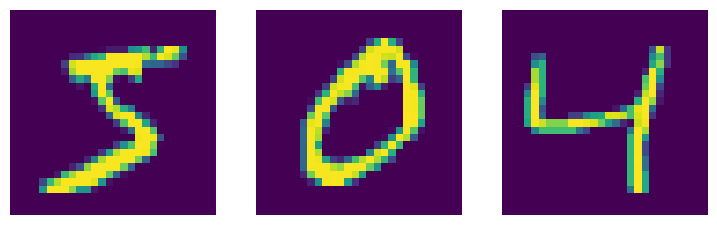

In [ ]:
from genaibook.core import show_images
show_images(mydata["train"]["image"][:3])

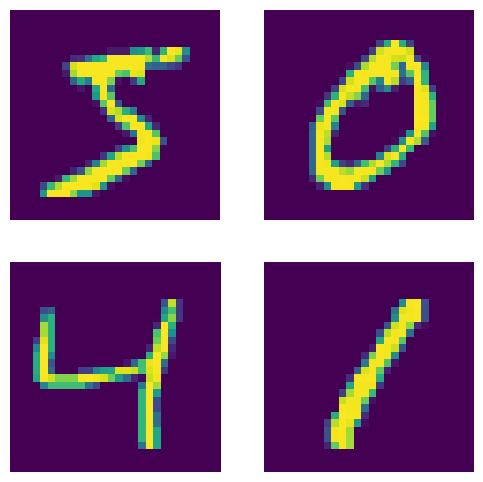

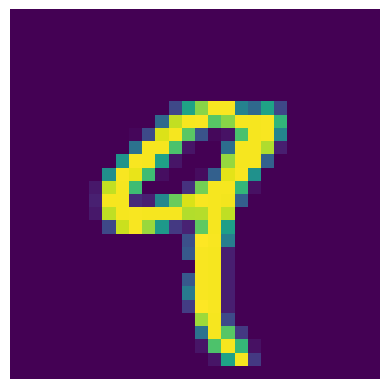

In [ ]:
show_images(mydata["train"]["image"][:5])

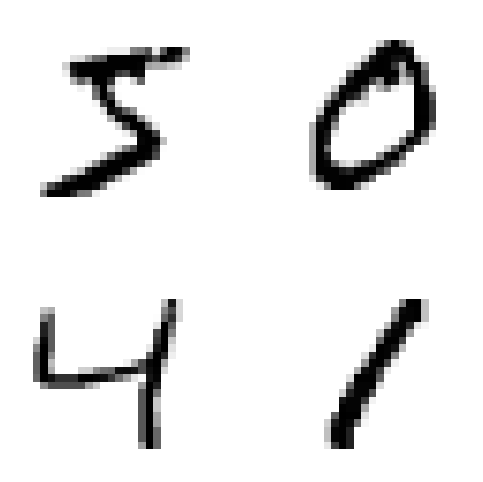

In [ ]:
import matplotlib as mpl

mpl.rcParams["image.cmap"] = "gray_r"


show_images(mydata["train"]["image"][:4])


#Creating a PyTorch DataLoader

To prepare the training data.

We will transform our images to Pytorch Tensors

In [ ]:
from torchvision import transforms


def mnist_to_tensor(samples):

  t = transforms.ToTensor()

  samples["image"] = [t(image) for image in samples["image"]]

  return samples

mydata = mydata.with_transform(mnist_to_tensor)

mydata["train"] = mydata["train"].shuffle(seed=1337)

In [ ]:
x = mydata["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

All images have the same size, and
therefore, all tensors have the same shape,

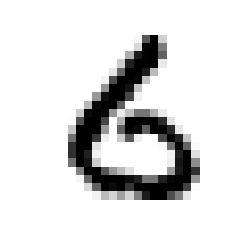

In [ ]:
show_images(mydata["train"]["image"][0])

In [ ]:
from torch.utils.data import DataLoader

bs = 64

train_dataloader = DataLoader(mydata["train"]["image"],

                              batch_size=bs)

# Streaming services like Netflix trains encoders + decoders so:
- Encoders embed ad creatives in  semantic space
- Decoders generate creative variations from those embeddings

# Encoder Implementation
The encoder extracts semantic embeddings used for ad search, ranking, similarity, and conditioning generative models.

The encoder is designed to accept any number of channels — meaning it also works for: RGB ad, video frames, thumbnails, and Creative assets.

In [ ]:
# Importing the nn (neural network) module from PyTorch’s torch library.
from torch import nn

In [ ]:
# defining a function for the encoder
def conv_block(in_channels, out_channels,

               kernel_size=4, stride=2,

               padding=1):


  return nn.Sequential(nn.Conv2d(in_channels,              # number of channels coming in

                                 out_channels,             # how many learn filters maps to create

                                 kernel_size = kernel_size,  # size of the convolution filter

                                 stride = stride,            # how far we move the filter at each step (skip 2 pixels at a time)

                                 padding = padding,          # how many pixels of zero-padding to add around the border.
                                 ),

                       nn.BatchNorm2d(out_channels),       # Adds a 2D batch normalization layer that normalizes each of the out_channels feature maps.

                       nn.ReLU(),                          # keep positive signals, drop negative ones. This lets the network learn complex patterns, not just straight lines.”
                       )

what does an encoder do?

An encoder converts ad creatives into dense semantic vectors used for search, ranking, safety, and generative models.

In [ ]:
# Architecting the Encoder

class Encoder(nn.Module):                     # This is the model that compresses a high-dimensional creative asset (image) into a low-dimensional semantic vector

  def __init__(self, in_channels):            # Initializes the encoder with the number of input channels.

    super().__init__()

    self.conv1 = conv_block(in_channels, 128) # The model begins by learning edge detectors, textures, and simple patterns.

    self.conv2 = conv_block(128, 256)         # The encoder now learns mid-level visual features

    self.conv3 = conv_block(256, 512)         # Now the encoder is learning semantic structures such as product boundaries, human faces, or pose components

    self.conv4 = conv_block(512, 1024)        # The entire image becomes a 1×1×1024 tensor. This is the high-level abstract “meaning.”

    self.linear = nn.Linear(1024, 16)         # This is the latent vector. The compact representation the AutoEncoder learns.



  # FORWARD PASS (THE ACTUAL COMPUTATION)
  def forward(self, x):

      x = self.conv1(x)  # (batch size, 128, 14, 14)
      x = self.conv2(x)  # (bs, 256, 7, 7)
      x = self.conv3(x)  # (bs, 512, 3, 3)
      x = self.conv4(x)  # (bs, 1024, 1, 1)

      # Keep batch size intact.
      x = self.linear(x.flatten(start_dim=1))  # (bs, 16)

      return x


# The final convolution produces a 1024-dimensional semantic embedding that captures the meaning of the creative.


What did we built?

We have built a convolutional encoder using a series of Conv → BatchNorm → ReLU blocks that progressively reduce spatial resolution while increasing channel depth. Each layer extracts increasingly abstract features. After reaching a 1024-channel bottleneck at 1×1 resolution, we flatten the representation and project it into a 16-dimensional latent vector. This serves as the compact embedding for similarity search, clustering, or generative reconstruction.

In [ ]:
# verifying that we can run our input images through the encoder.
# Check the shape of one image

mydata["train"]["image"][0].shape

torch.Size([1, 28, 28])

Creating a new dimension with
PyTorch’s None indexing, by selecting and put a single image inside a batch

In [ ]:
# Set how many input channels we have
in_channels = 1

# Put one image into a batch
x = mydata["train"]["image"][0][None, :]

# Create the encoder and switch to eval/testing mode
encoder = Encoder(in_channels).eval()

# Run the image through the encoder
# We successfully compressed 784 pixels, 28 × 28 images → 16 numbers.
encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

The encoder model  have successfully converted  28 × 28 images (784 pixels each) into vectors with just 16 numbers. If we can train it effectively, the representations computed by the encoder will have much lower dimensionality than the original pixel data.

In [ ]:
# Remember the representations are currently meaningless, as the model is yet to
# be trained
encoded

tensor([[-0.0131, -0.0154, -0.0353, -0.0136,  0.0142, -0.0104, -0.0173, -0.0020,
          0.0064, -0.0241,  0.0135, -0.0264,  0.0138, -0.0200, -0.0287,  0.0185]],
       grad_fn=<AddmmBackward0>)

Test on a whole batch of 64 images

In [ ]:
batch = next(iter(train_dataloader))

encoded = Encoder(in_channels=1)(batch)

batch.shape, encoded.shape
# (torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))


(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

#Decoder

Our decoder takes the small latent vector — essentially the compressed meaning of a creative — and reconstructs a full image by first expanding it through a linear layer into a small 4×4 feature grid, then using a series of transposed convolutions to gradually increase spatial resolution while reducing channel depth.

This mirrors how generative models like Stable Diffusion upscale latent representations into full-resolution ads.

In [ ]:
def conv_transpose_block(    # Transposed convolution expands the image resolution. Only use by Decoder

    in_channels,

    out_channels,

    kernel_size = 3,

    stride = 2,

    padding = 1,

    output_padding = 0,      # When you “stretch” an image, you sometimes need a tiny patch to make the math line up → that’s output_padding.

    with_act = True,         # option to turn on/off activation (with with_act=False).

):
    modules = [

        nn.ConvTranspose2d(

            in_channels,

            out_channels,

            kernel_size = kernel_size,

            stride = stride,

            padding = padding,

            output_padding = output_padding,

        ),
    ]

    if with_act:  # Controling this will be handy later

        modules.append(nn.BatchNorm2d(out_channels))

        modules.append(nn.ReLU())

    return nn.Sequential(*modules)

This is how Stable Diffusion decoders start:

- Tiny latent → dense feature grid → upscale to full image.

In [ ]:
class Decoder(nn.Module):

    def __init__(self, out_channels):

        super().__init__()

        self.linear = nn.Linear(16, 1024 * 4 * 4)  # note it's reshaped in forward

        self.t_conv1 = conv_transpose_block(1024, 512)

        self.t_conv2 = conv_transpose_block(512, 256, output_padding=1)

        self.t_conv3 = conv_transpose_block(256, out_channels, output_padding=1)

    def forward(self, x):

        bs = x.shape[0]

        x = self.linear(x)  # (bs, 1024*4*4)

        x = x.reshape((bs, 1024, 4, 4))  # (bs, 1024, 4, 4)
        x = self.t_conv1(x)  # (bs, 512, 7, 7)
        x = self.t_conv2(x)  # (bs, 256, 14, 14)
        x = self.t_conv3(x)  # (bs, 1, 28, 28)

        return x

#Trainning

We are teaching the system to represent images compactly AND decode them.

The AutoEncoder succeeds when:
- Decoder learns to reconstruct images well
- Encoder learns to compress images to meaningful features
- Latent vectors hold semantic information


image → Encoder → latent → Decoder → reconstructed image

This training style is how Netflix learns:

- Creative embeddings
- Brand-safe features
- Ad-style representation
- Latent spaces for diffusion models


This is foundational for:
- Creative ranking
- Semantic search
- Generative ads
- Multimodal alignment
- Ad similarity scoring

If training works:

- Encoders produce meaningful creative embeddings
- Decoders generate realistic ad frames
- Latents encode brand identity, color palette, product layout, etc.


Once trained:

- We can use just the encoder → to get latent vectors for any image
- We can use just the decoder → to generate new images from random latent vectors
- We can use them together → for reconstruction

This makes AutoEncoders extremely versatile.

In [ ]:
class AutoEncoder(nn.Module):

    def __init__(self, in_channels):

        super().__init__()
        self.encoder = Encoder(in_channels)   # the Encoder → compresses images to latent vectors

        self.decoder = Decoder(in_channels)   # the Decoder → expands latent vectors back to images

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))   # Return reconstructed image

This training loop above:
- Load a batch of images
- Send them through AutoEncoder
- Compute reconstruction loss
- Backpropagate
- Update weights
- Repeat for all batches and all epochs

Trainning Path
image → encoder → latent(16) → decoder → reconstructed image


In [ ]:
model = AutoEncoder(1)

AutoEncoders are the backbone of Netflix’s for:
- Creative reconstruction
- Latent diffusion
- Semantic embedding
- Ad creative generation
- Multimodal alignment pipelines


The AutoEncoder class wraps an encoder and decoder into a single PyTorch module. The encoder compresses images into a latent vector, the decoder reconstructs them, and forward() passes inputs through both to minimize reconstruction error during training. It also exposes separate encode and decode methods, allowing the encoder or decoder to be used independently — critical for tasks like creative embeddings, reconstruction, and generative pipelines.

We have created a simple training loop that repeatedly goes through
the training data and uses a constant learning rate.



In [ ]:
import torchsummary

torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

We have trained an AutoEncoder end-to-end using a reconstruction loss.
The encoder learns a compressed latent representation (16-D),
and the decoder learns to reconstruct the input image from this latent.
The summary shows how convolutional downsampling and transposed convolutional upsampling form a symmetric bottleneck architecture capable of learning meaning-rich embeddings.
This setup is foundational for diffusion models, creative generation, and ad-semantic understanding

Next we will:
- Load a batch from the DataLoader.
- Get the model predictions.
- Calculate the loss with respect to the original images.
- Perform an optimizer step to update the model weights.

In [ ]:
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange
from genaibook.core import get_device

In [ ]:

num_epochs = 2

lr = 1e-4


device = get_device('cpu')                                                              # Model must live on CPU or GPU so it can work.

model = model.to(device)



optimizer = torch.optim.AdamW(model.parameters(), lr = lr,  eps=1e-5)                   # AdamW updates the weights of the neural network.




losses = []                                                                            # List to store the loss values for plotting. We’ll store how “bad” the reconstruction is over time.


for _ in (progress := trange(num_epochs,desc = "Training")):                           # Repeat training 10 times



    for _, batch in (inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))): # Go through all the training images in small batches


        batch = batch.to(device)                                                       # Move batch to device


        # Pass images through model
        preds = model(batch)

        # Compare the decoder output to the original input pixel by pixel.
        # Computing reconstruction loss
        loss = F.mse_loss(preds, batch)


        # Log the loss and store for plotting
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")

        # Save the loss
        losses.append(loss.item())



        # Backpropagation, computes gradients = how much each weight contributed to the error
        loss.backward()

        # Update weights, Optimizer nudges each weight slightly to reduce future errors
        optimizer.step()

        # reset gradient, Clears previous gradients so they don’t accumulate.
        optimizer.zero_grad()

    # Update outer progress bar, Shows final loss for the epoch.
    progress.set_postfix(loss = f"{loss.cpu().item():.3f}")

This training the backbone of:

- Creative embedding models (like CLIP)
- Ad similarity scoring
- Brand-safety models
- Latent diffusion (SD-based ad generation)
- Creative optimization loops
- Multimodal ad/copy alignment

This training loop is identical to what Netflix teams use to train:

- VAEs
- Latent diffusion models
- Multimodal embeddings
- Semantic encoders for ad intelligence

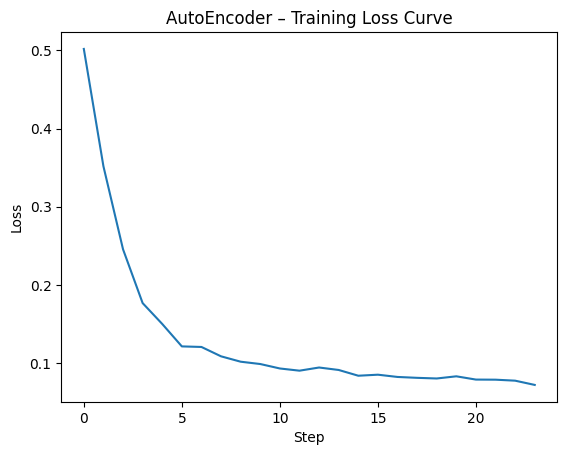

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("AutoEncoder – Training Loss Curve")
plt.show()

After training a creative model, Netflix tests using held-out creatives:

- unseen ads
- unseen thumbnails
- unseen product photos

This ensures the model generalized, not memorized.

#Evaluation mode



We can actually see what the AutoEncoder learned.

Switches the AutoEncoder to evaluation mode:
- Turns off Dropout
- BatchNorm uses stored running averages
- No gradients
- Stable inference

In [ ]:
# First we create a DataLoader around the test set to have iur Autoencoder
# evaluate 16 images at a time

eval_bs = 16

eval_dataloader = DataLoader(mydata["test"]["image"],

                             batch_size = eval_bs)

Eval mode = Production inference mode
Used for:
- Generating ad previews
- Evaluating creative embeddings
- Running classifiers on creatives
- Brand safety checks

In [ ]:
# 2 Put the model in eval mode
model.eval()

AutoEncoder(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv4): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (linear): Linear(in_features=1024, out_features=16, bias=True)
  )
  (decoder): D

Let’s once again load the trained model and look at some reconstructions

In [ ]:
# 3 disable gradient computations which mean
# No gradient tracking, No backward pass, Faster and safer.
with torch.inference_mode():


    # 4. Get one evaluation batch
    eval_batch = next(iter(eval_dataloader))


    # 5. Generate reconstructed images
    # This is latent interpretability
    predicted = model(eval_batch.to(device)).cpu()

This is how Netflix checks:

- Creative reconstruction quality
- embedding → decoder consistency
- What latent space is preserving

It reveals:

- what features the model learns
- what digits it confuses
- what variations it can generate

This is latent interpretability.

# Compare originals with predictions

We create a single tensor:

- First 16 images = originals
- Next 16 images = reconstructions

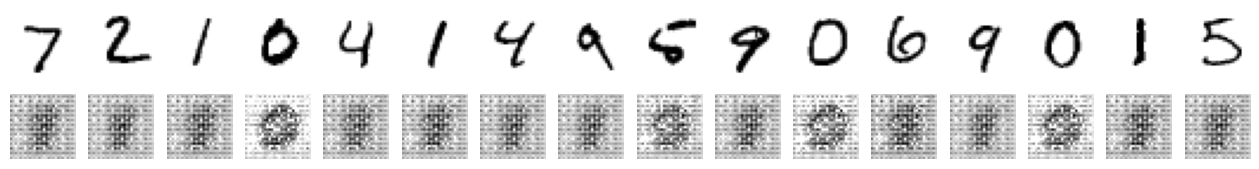

In [ ]:
# Tensor created for preds and original
batch_vs_preds = torch.cat((eval_batch, predicted))

show_images(batch_vs_preds,

            imsize = 1,

            nrows = 2)

This is how Netflix teams visually inspect:

- Reconstruction quality
- Creative realism
- Latent compression loss
- Feature preservation
- Distortion of brand elements

This is essential for generative ad pipelines — especially training VAEs & diffusion models.

#Latent Space

We will implement an identical Encoder, decoder and AE

We will transform our AutoEncoder from a simple compressor into a latent representation research tool!

By using sigmoid as the activation function, we ensure that the output after each layer lies within the
range (0, 1), the same range the input images use.

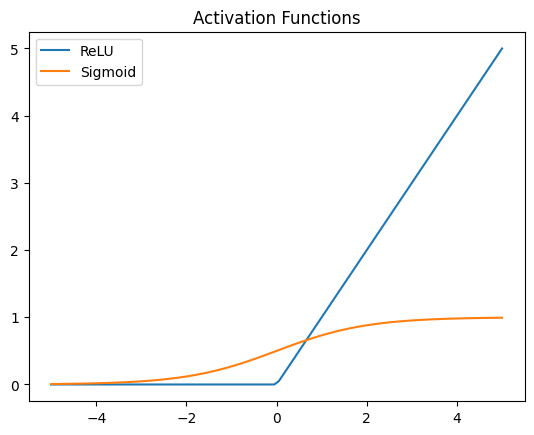

In [ ]:
# Plot of the ReLU versus the sigmoid function.
def plot_activation_fn(fn, name):

    x = torch.linspace(-5, 5, 100)

    y = fn(x)

    plt.plot(x, y, label = name)

    plt.legend()



plt.title("Activation Functions")

plot_activation_fn(F.relu, "ReLU")

plot_activation_fn(F.sigmoid, "Sigmoid")

In [ ]:

class Encoder(nn.Module):

    def __init__(self, in_channels, latent_dims):

        super().__init__()

        self.conv_layers = nn.Sequential(

            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )
        self.linear = nn.Linear(1024, latent_dims)


    def forward(self, x):

        bs = x.shape[0]

        x = self.conv_layers(x)

        x = self.linear(x.reshape(bs, -1))
        return x

At Netflix this mirrors production architectures:

- Modular blocks
- configurable depth
- easy to experiment
- important for rapid prototyping

Netflix Ads team needs to experiment with:

- Different encoder depths
- Different bottlenecks
- Large-scale creative datasets

This refactor makes that easier.

In [ ]:
class Decoder(nn.Module):

  def __init__(self, out_channels, latent_dims):

            super().__init__()

            self.linear = nn.Linear(latent_dims, 1024 * 4 * 4)

            self.t_conv_layers = nn.Sequential(

                conv_transpose_block(1024, 512),

                conv_transpose_block(512, 256, output_padding = 1),

                conv_transpose_block(256, out_channels,

                                     output_padding = 1,

                                     with_act = False ),
                )

            self.sigmoid = nn.Sigmoid()


  def forward(self, x):

    bs = x.shape[0]

    x = self.linear(x)

    x = x.reshape((bs, 1024, 4, 4))

    x = self.t_conv_layers(x)

    x = self.sigmoid(x)
    return x


In [ ]:
class AutoEncoder(nn.Module):

  def __init__(self, in_channels, latent_dims):

            super().__init__()

            self.encoder = Encoder(in_channels, latent_dims)

            self.decoder = Decoder(in_channels, latent_dims)

  def encode(self, x): return self.encoder(x)

  def decode(self, x): return self.decoder(x)

  def forward(self, x):

    return self.decode(self.encode(x))

The training loop is the same as before, but we put it inside a function to reuse it and call it whenever needed

In [ ]:
def train(model, num_epochs=2, lr=1e-2):

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

    model.train()  # Put model in training mode

    losses = []

    for _ in (progress := trange(num_epochs, desc="Training")):

        for _, batch in (

            inner := tqdm(

                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through the model and obtain another set of images
            preds = model(batch)

            # Compare the prediction with the original images
            loss = F.mse_loss(preds, batch)

            # Display loss and store for plotting
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")

            losses.append(loss.item())


            # Update the model parameters with the optimizer based on this loss
            loss.backward()

            optimizer.step()

            optimizer.zero_grad()

        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")

    return losses

In [ ]:
ae_model = AutoEncoder(in_channels=1, latent_dims=2)
ae_model.to(device)


AutoEncoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (linear): Linear(in_

In [ ]:
losses = train(ae_model)

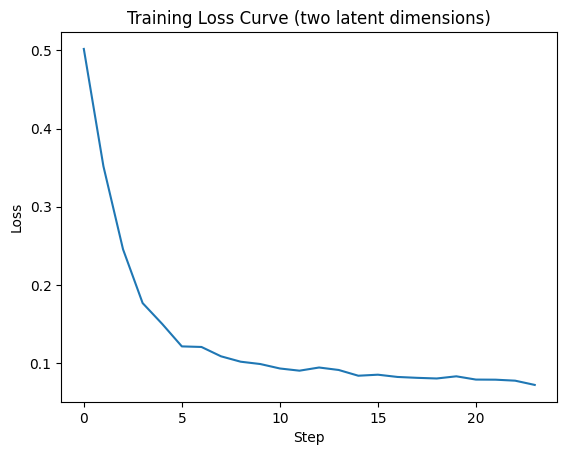

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve (two latent dimensions)")
plt.show()

We restructured the AutoEncoder to make the latent dimensionality configurable, enabling both higher compression and visualization of the latent space. We replaced the final activation with sigmoid to match the pixel distribution, modularized the architecture via nn.Sequential, and wrapped training into a reusable function. These changes transform the AutoEncoder into an analysis tool that reveals how different inputs are represented in latent space — a core concept behind generative modeling and multimodal systems like those used in Netflix Ads.

This is how Netflix evaluates:
- creative clustering
- semantic spaces
- ad similarity maps
- latent interpolation quality

They often reduce dimensions to visualize:

- Clusters of ad creatives
- Clusters of product categories
- Emotional tone
- Brand style

#Visualizing the Latent Space

In [ ]:
images_labels_dataloader = DataLoader(mydata["test"], batch_size=512)

In [ ]:
import pandas as pd

df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(
    iter(images_labels_dataloader), total=len(images_labels_dataloader)
):
    encoded = ae_model.encode(batch["image"].to(device)).cpu()
    new_items = {
        "x": [t.item() for t in encoded[:, 0]],
        "y": [t.item() for t in encoded[:, 1]],
        "label": batch["label"],
    }
    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

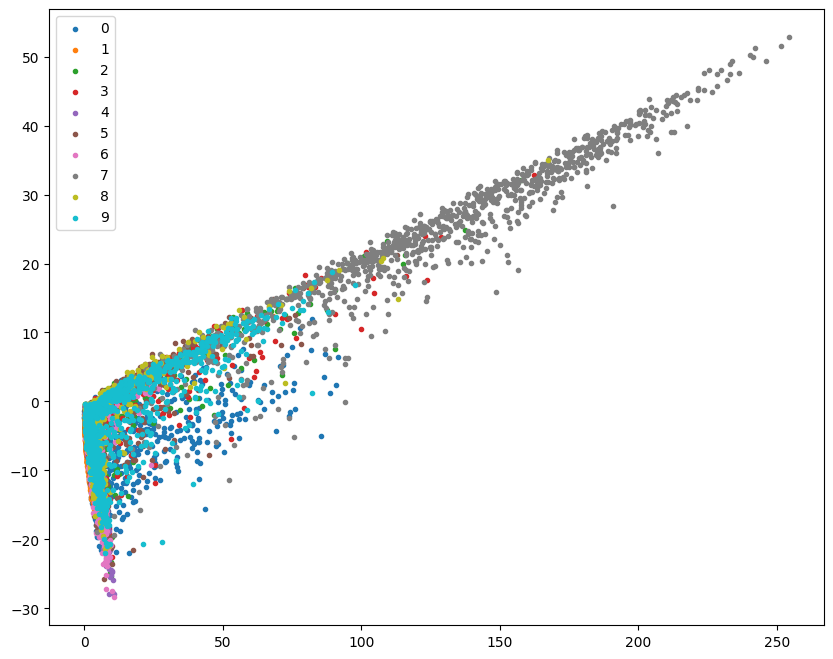

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):

  points = df[df["label"] == label]

  plt.scatter(points["x"], points["y"], label=label, marker=".")

  plt.legend();

Let’s see an example of image generation with the decoder

In [ ]:
N = 16 # We'll generate 16 points

z = torch.rand((N, 2)) * 8 - 4

#Latent Space Visualization

Visualizing the generated latent samples overlayed on top of the latent space representation we showed befor

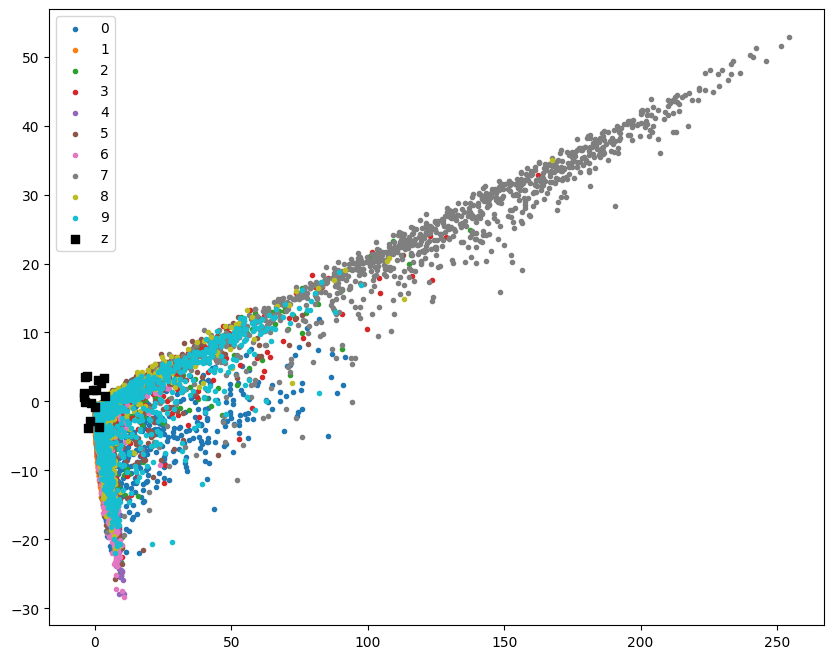

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):

  points = df[df["label"] == label]

  plt.scatter(points["x"],
              points["y"],
              label=label,
              marker=".")

plt.scatter(z[:, 0],
            z[:, 1],
            label="z",
            marker="s",
            color="black")

plt.legend();

Let’s ask the decoder to generate images from the latent samples we just created.

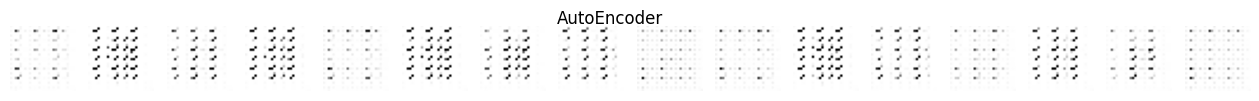

In [ ]:
ae_decoded = ae_model.decode(z.to(device))

show_images(ae_decoded.cpu(),

            imsize = 1,

            nrows = 1,

            suptitle = "AutoEncoder")

#Variational AutoEncoders


Using a a multivariate Gaussian

- Isotropic Gaussian
- Diagonal covariance

The VAE has two goals: reconstruct the image (like before) and Shape the latent space, as well as, forces the latent space to be:

- Smooth
- Continuous
- Gaussian-shaped distribution
- Evenly distributed
- Interpolatable (good for generation)


In [ ]:
# Lets Build the Encoder.We will not build a decoder, it stay the same.
# We will simply call it from the last sessions

class VAEEncoder(nn.Module):

    def __init__(self, in_channels, latent_dims):
        super().__init__()

        # extract high-level features from the image
        # Then compress the image into a 1024-feature representation.
        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )

        # Define fully connected layers for mean and log-variance

        # learn the center of the Gaussian
        self.mu = nn.Linear(1024, latent_dims)

        # Learn the spread of the Gaussian
        self.logvar = nn.Linear(1024, latent_dims)

    def forward(self, x):

        bs = x.shape[0]

        x = self.conv_layers(x)
        x = x.reshape(bs, -1)

        mu = self.mu(x)
        logvar = self.logvar(x)

        return (mu, logvar)

In [ ]:
class VAE(nn.Module):

    def __init__(self, in_channels, latent_dims):

        super().__init__()

        self.encoder = VAEEncoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):

        # Returns mu, log_var
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Obtain parameters of the normal (Gaussian) distribution
        mu, logvar = self.encode(x)

        # Sample from the distribution
        std = torch.exp(0.5 * logvar)
        z = self.sample(mu, std)

        # Decode the latent point to pixel space
        reconstructed = self.decode(z)

        # Return the reconstructed image, and also the mu and logvar
        # so we can compute a distribution loss
        return reconstructed, mu, logvar

    def sample(self, mu, std):
        # Reparametrization trick
        # Sample from N(0, I), translate and scale
        eps = torch.randn_like(std)
        return mu + eps * std

Sampling from the Encoder Distribution

In [ ]:
def vae_loss(batch, reconstructed, mu, logvar):

    bs = batch.shape[0]

    # Reconstruction loss from the pixels - 1 per image
    reconstruction_loss = F.mse_loss(

        reconstructed.reshape(bs, -1),

        batch.reshape(bs, -1),

        reduction="none",

    ).sum(dim=-1)

    # KL-divergence loss, per input image
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    # Combine both losses and get the mean across images
    loss = (reconstruction_loss + kl_loss).mean(dim=0)

    return (loss, reconstruction_loss, kl_loss)

Traiining The VAE, We're using the same scripts from the last session.

In [ ]:
def train_vae(model, num_epochs = 2, lr = 1e-4):

    model = model.to(device)
    losses = {

        "loss": [],
        "reconstruction_loss": [],
        "kl_loss": [],
    }

    model.train()

    optimizer = torch.optim.AdamW(model.parameters(),

                                  lr = lr, eps = 1e-5)

    for _ in (progress := trange(num_epochs, desc="Training")):

        for _, batch in (

            inner := tqdm(

                enumerate(train_dataloader),
                total = len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through the model
            reconstructed, mu, logvar = model(batch)

            # Compute the losses
            loss, reconstruction_loss, kl_loss = vae_loss(
                batch, reconstructed, mu, logvar
            )

            # Display loss and store for plotting
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")

            losses["loss"].append(loss.item())

            losses["reconstruction_loss"].append(

                reconstruction_loss.mean().item()
            )
            losses["kl_loss"].append(kl_loss.mean().item())

            # Update model parameters based on the total loss
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [ ]:
vae_model = VAE(in_channels = 1,

                latent_dims=2)

In [ ]:
losses = train_vae(vae_model,

                   num_epochs = 2,

                   lr = 1e-4)

In [ ]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend();

 Reconstructing some images and visualize the results of VAE reconstructions from MNIST samples:

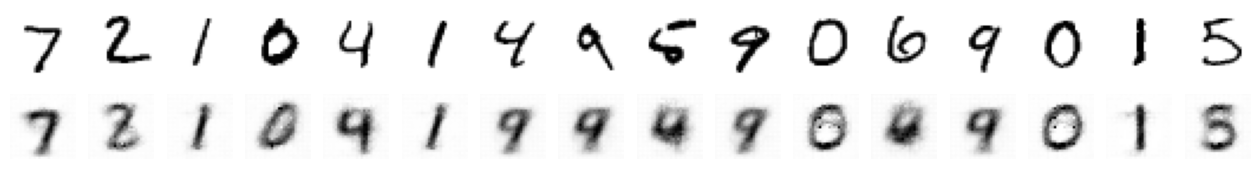

In [ ]:
vae_model.eval()

with torch.inference_mode():

  eval_batch = next(iter(eval_dataloader))

  predicted, mu, logvar = (v.cpu() for v in vae_model(eval_batch.to(device)))


batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

Visualisations

In [ ]:
df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(

    iter(images_labels_dataloader),

    total=len(images_labels_dataloader)
):
    mu, _ = vae_model.encode(batch["image"].to(device))
    mu = mu.to("cpu")
    new_items = {
        "x": [t.item() for t in mu[:, 0]],
        "y": [t.item() for t in mu[:, 1]],
        "label": batch["label"],
    }
    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

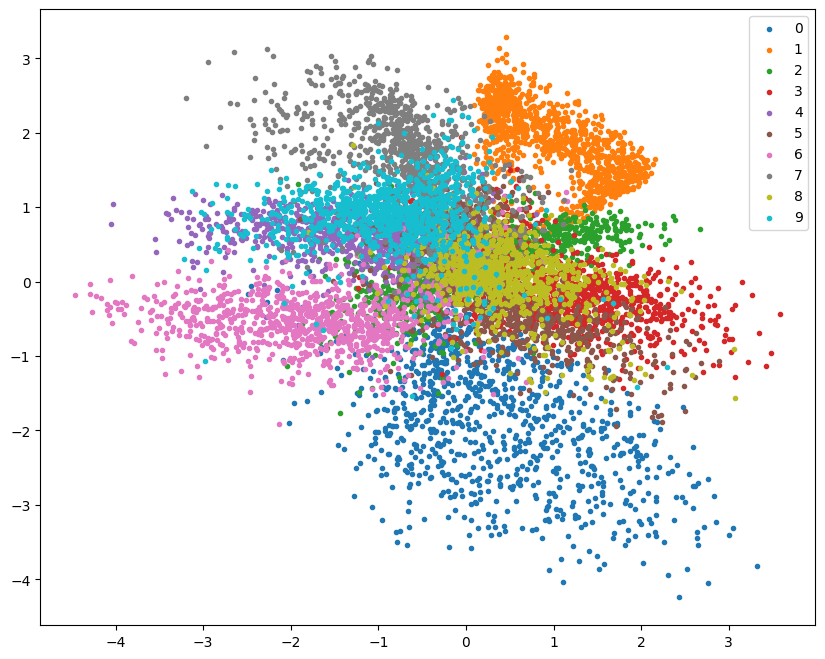

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.legend();

Sampling random data from the distribution and, hopefully, obtain images that resemble our input dataset

In [ ]:
z = torch.normal(0, 1, size=(10, 2))

ae_decoded = ae_model.decode(z.to(device))

vae_decoded = vae_model.decode(z.to(device))

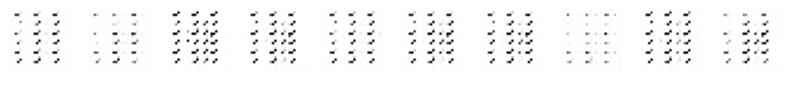

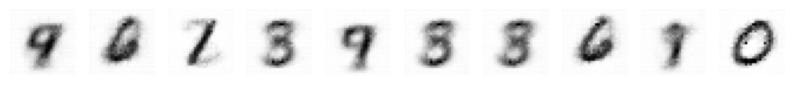

In [ ]:
show_images(ae_decoded.cpu(), imsize=1, nrows=1)

show_images(vae_decoded.cpu(), imsize=1, nrows=1)

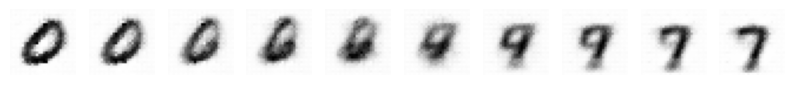

In [ ]:
import numpy as np

with torch.inference_mode(): inputs = []

for y in np.linspace(-2, 2, 10): inputs.append([-0.8, y])


z = torch.tensor(inputs, dtype=torch.float32).to(device)
decoded = vae_model.decode(z)


show_images(decoded.cpu(), imsize=1, nrows=1)


This is a visual representation of what the model learned,

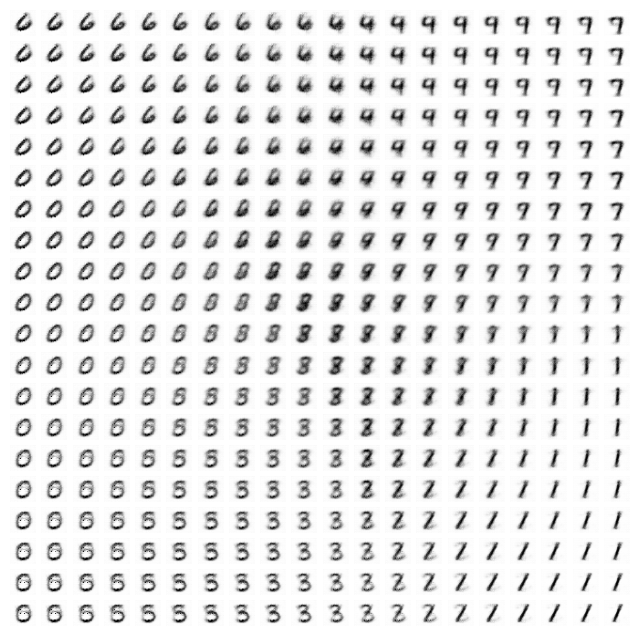

In [ ]:
inputs = []

for x in np.linspace(-2, 2, 20):

  for y in np.linspace(-2, 2, 20):

    inputs.append([x, y])

z = torch.tensor(inputs, dtype=torch.float32).to(device)
decoded = vae_model.to(device).decode(z)

show_images(decoded.cpu(), imsize=0.4, nrows=20)

VAEs learn probability distributions (mean + variance) for each latent dimension, use reparametrization to sample differentiably from them, and output log-variance instead of variance for numerical stability.